# `kissim`-based kinome tree

We generate `kissim`-based kinome matrices and trees based on three different parameters:

- Feature weighting schemes
- DFG conformations
  - Kinase matrix based on all structures/fingerprints (**DFG-in and DFG-out**)
  - Kinase matrix based on structure/fingerprints in **DFG-in** conformation only
  - Kinase matrix based on structure/fingerprints in **DFG-out** conformation only
- Clustering methods

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio import Phylo
from opencadd.databases.klifs import setup_remote
from IPython.display import display, Markdown

from kissim.comparison import FingerprintDistanceGenerator
from kissim.comparison import matrix, tree

In [6]:
matplotlib.rc("font", size=6)

In [7]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results"

In [5]:
# Set bit coverage between fingerprint pairs
COVERAGE_MIN = 0.8
WEIGHTING_SCHEMES = ["15", "110", "101", "100"]
DFG_CONFORMATIONS = ["all", "in", "out"]
CLUSTERING_METHODS = ["ward", "average", "weighted"]
FIG_HEIGHT = {"all": 25, "in": 25, "out": 10}

## Data

- 20210630 KLIFS download
- DFG-all/in/out

## Kinase-color mapping

In [6]:
klifs_session = setup_remote()
kinases = klifs_session.kinases.all_kinases(species="Human")
kinases = klifs_session.kinases.by_kinase_klifs_id(kinases["kinase.klifs_id"].to_list())
kinases = kinases[["kinase.klifs_name", "kinase.group"]]
kinase_groups = kinases["kinase.group"].sort_values().unique()
colors = [
    "red",
    "orange",
    "yellowgreen",
    "limegreen",
    "turquoise",
    "cornflowerblue",
    "grey",
    "mediumblue",
    "darkorchid",
    "violet",
]
groups_to_color = {g: c for g, c in zip(kinase_groups, colors)}
kinases["color"] = kinases["kinase.group"].apply(lambda x: groups_to_color[x])
label_colors = kinases.set_index("kinase.klifs_name")["color"].to_dict()
LABEL_COLORS = label_colors

## Helper functions

In [7]:
def generate_trees(
    path_results=RESULTS,
    weighting_schemes=WEIGHTING_SCHEMES,
    dfg_conformations=DFG_CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    coverage_min=COVERAGE_MIN,
):
    def _load_fingerprint_distances(path_results, weighting):
        """
        Load fingerprint distances (all conformations).
        """

        if weighting == "15":
            filepath = path_results / "fingerprint_distances.csv"
        else:
            filepath = path_results / f"fingerprint_distances_{weighting}.csv"
        fingerprint_distances = FingerprintDistanceGenerator.from_csv(filepath)

        return fingerprint_distances.data

    def _generate_distance_matrix(distances, coverage_min, weighting, path):
        """
        Generate and save distance matrix.
        """
        distance_matrix = matrix.kinase_distance_matrix(
            distances,
            by="minimum",
            fill_diagonal=True,
            coverage_min=coverage_min,
        )
        distance_matrix.to_csv(path / f"kinase_matrix_{coverage_min}_{weighting}.csv")
        return distance_matrix

    def _generate_tree(distance_matrix, weighting, cmethod, coverage_min, path):
        """
        Generate and save tree.
        """
        tree.from_distance_matrix(
            distance_matrix,
            path / f"tree_{coverage_min}_{weighting}_{cmethod}.tree",
            clustering_method=cmethod,
        )

    for dfg in dfg_conformations:
        path = RESULTS / f"dfg_{dfg}"
        print(path)
        (path / "matrices").mkdir(parents=True, exist_ok=True)
        (path / "trees").mkdir(parents=True, exist_ok=True)

        for weighting in weighting_schemes:
            distances = _load_fingerprint_distances(path, weighting)
            distance_matrix = _generate_distance_matrix(
                distances, coverage_min, weighting, path / "matrices"
            )
            for cmethod in clustering_methods:
                print(f"{weighting}_{dfg}_{cmethod}_{coverage_min}")
                _generate_tree(distance_matrix, weighting, cmethod, coverage_min, path / "trees")

In [8]:
def visualize_trees(
    path_results=RESULTS,
    weighting_schemes=WEIGHTING_SCHEMES,
    dfg_conformations=DFG_CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    fig_height=FIG_HEIGHT,
    label_colors=LABEL_COLORS,
    coverage_min=COVERAGE_MIN,
):
    for weighting in weighting_schemes:
        display(Markdown(f"### Weighing {weighting}"))
        for dfg in dfg_conformations:
            display(Markdown(f"#### DFG-{dfg}"))
            for cmethod in clustering_methods:
                display(Markdown(f"##### {cmethod}"))
                path_newick = (
                    path_results
                    / f"dfg_{dfg}/trees"
                    / f"tree_{coverage_min}_{weighting}_{cmethod}.tree"
                )
                kissim_tree = Phylo.read(path_newick, "newick")
                kissim_tree.ladderize()  # Flip branches so deeper clades are displayed at top

                fig, ax = plt.subplots(1, 1, figsize=(5, fig_height[dfg]))
                ax.set_title(
                    f"weighting {weighting} | DFG-{dfg} "
                    f"| cmethod {cmethod} | {kissim_tree.count_terminals()} leafs"
                )
                Phylo.draw(kissim_tree, axes=ax, label_colors=label_colors)

In [9]:
%%time
generate_trees()

/home/dominique/Documents/GitHub/kissim_app/notebooks/005_comparison/../../results/dfg_all
15_all_ward_0.8
15_all_average_0.8
15_all_weighted_0.8
110_all_ward_0.8
110_all_average_0.8
110_all_weighted_0.8
101_all_ward_0.8
101_all_average_0.8
101_all_weighted_0.8
100_all_ward_0.8
100_all_average_0.8
100_all_weighted_0.8
/home/dominique/Documents/GitHub/kissim_app/notebooks/005_comparison/../../results/dfg_in
15_in_ward_0.8
15_in_average_0.8
15_in_weighted_0.8
110_in_ward_0.8
110_in_average_0.8
110_in_weighted_0.8
101_in_ward_0.8
101_in_average_0.8
101_in_weighted_0.8
100_in_ward_0.8
100_in_average_0.8
100_in_weighted_0.8
/home/dominique/Documents/GitHub/kissim_app/notebooks/005_comparison/../../results/dfg_out
15_out_ward_0.8
15_out_average_0.8
15_out_weighted_0.8
110_out_ward_0.8
110_out_average_0.8
110_out_weighted_0.8
101_out_ward_0.8
101_out_average_0.8
101_out_weighted_0.8
100_out_ward_0.8
100_out_average_0.8
100_out_weighted_0.8
CPU times: user 4min 28s, sys: 17.3 s, total: 4min 45

### Weighing 15

#### DFG-all

##### ward

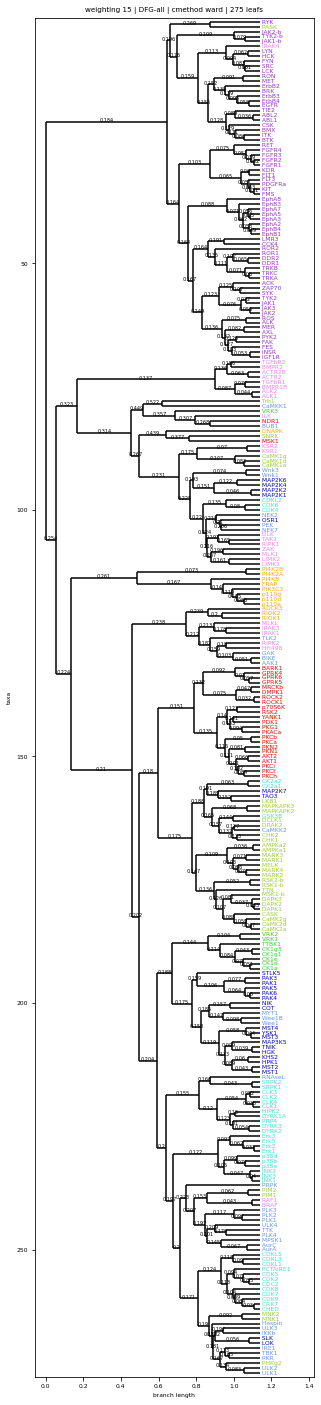

##### average

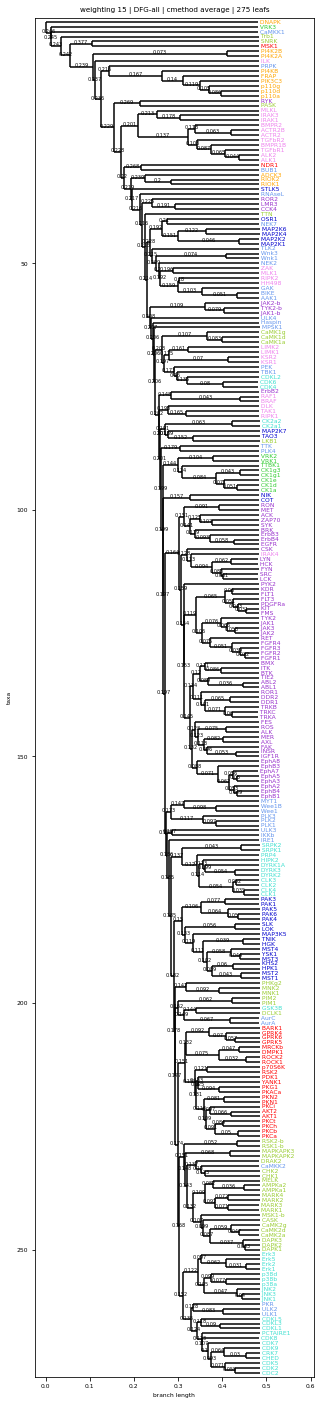

##### weighted

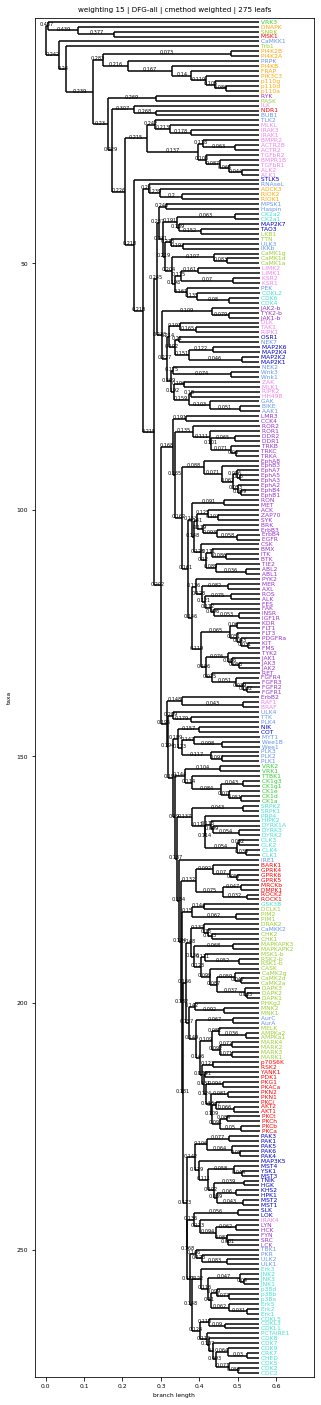

#### DFG-in

##### ward

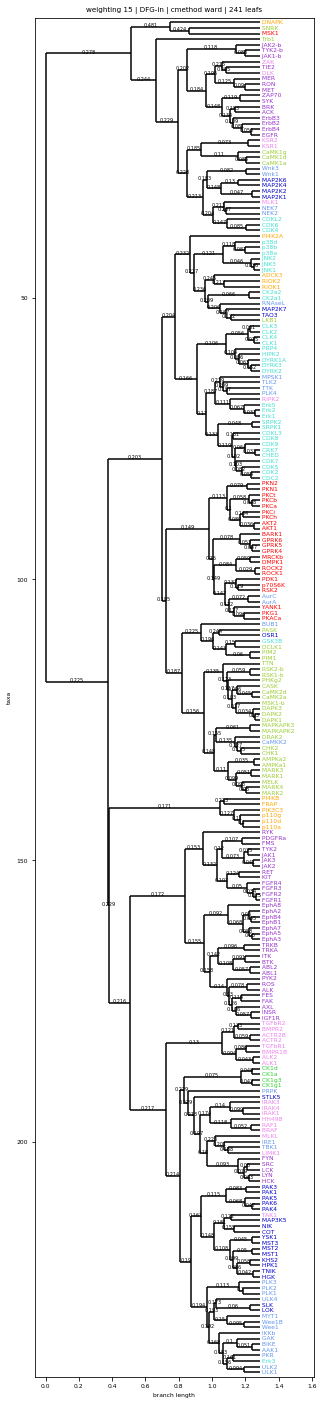

##### average

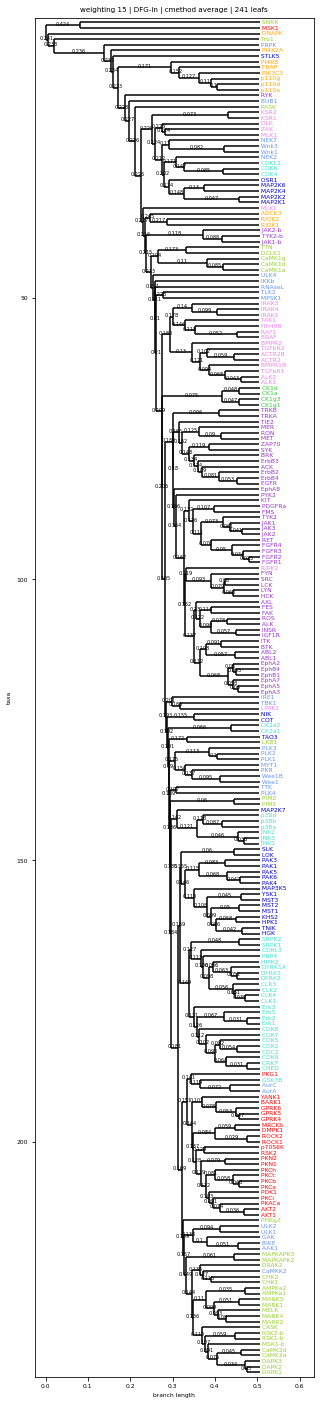

##### weighted

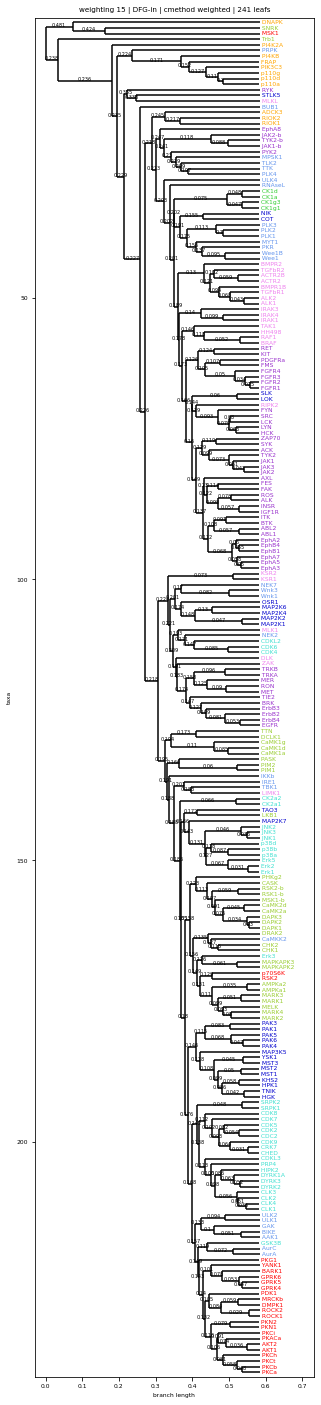

#### DFG-out

##### ward

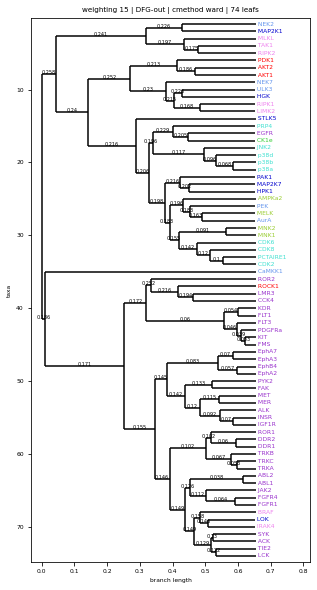

##### average

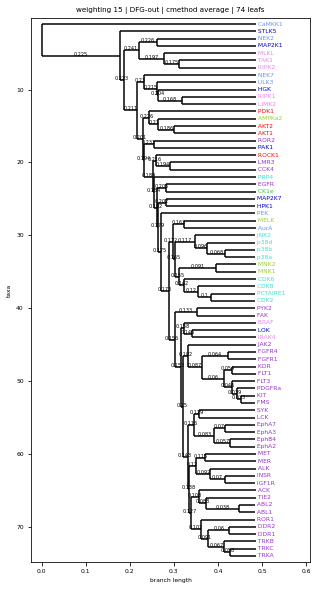

##### weighted

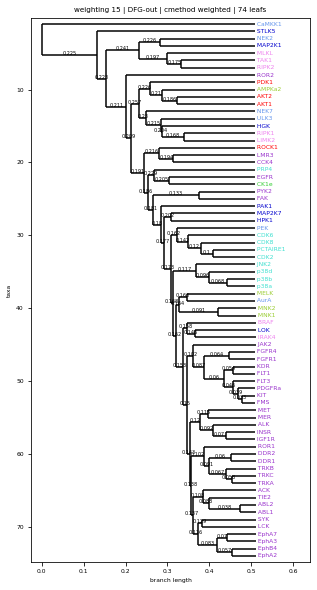

### Weighing 110

#### DFG-all

##### ward

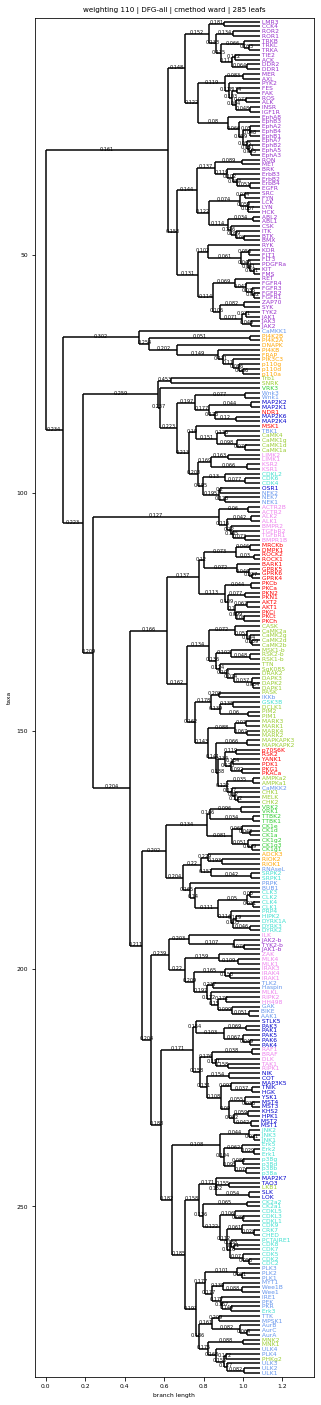

##### average

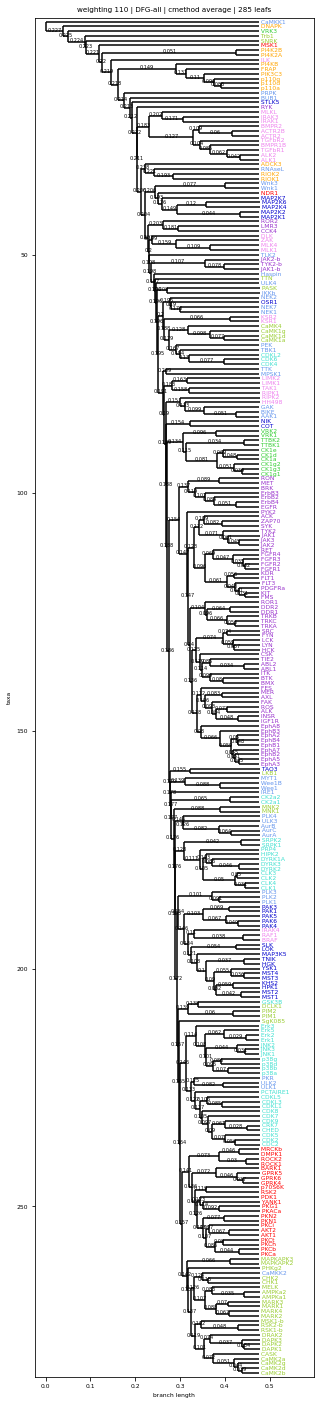

##### weighted

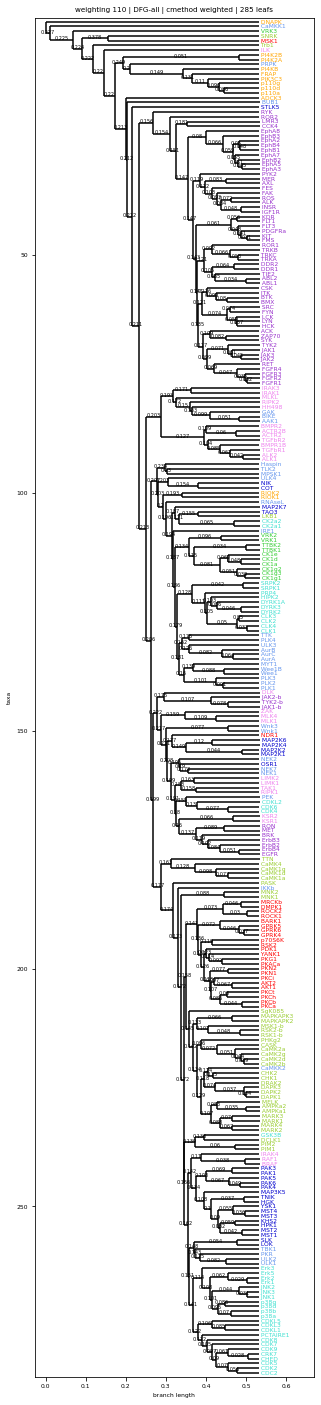

#### DFG-in

##### ward

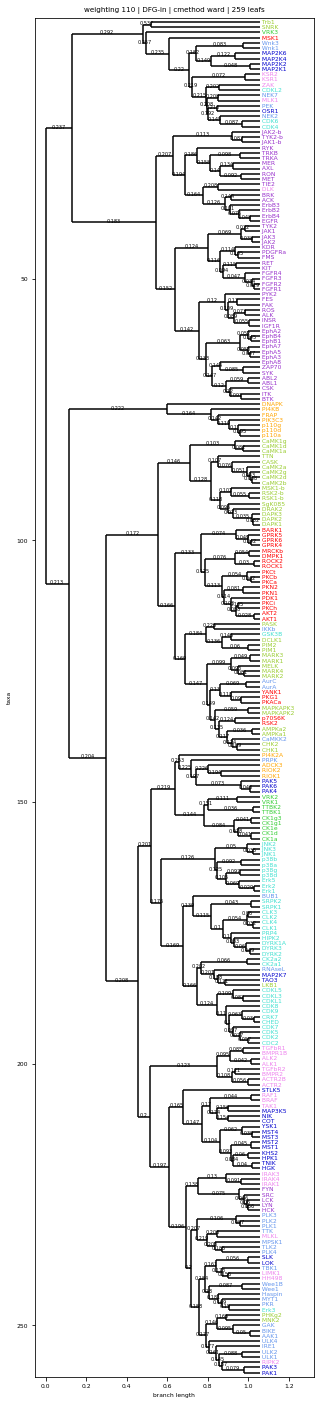

##### average

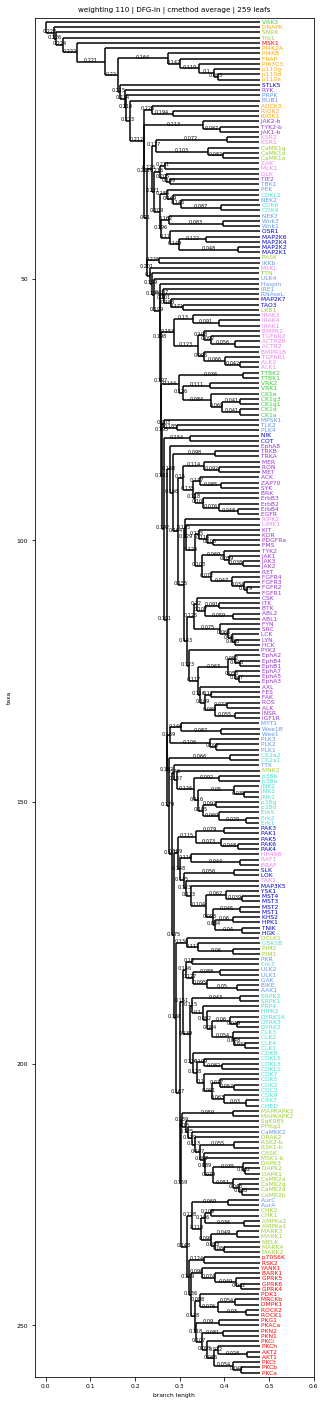

##### weighted

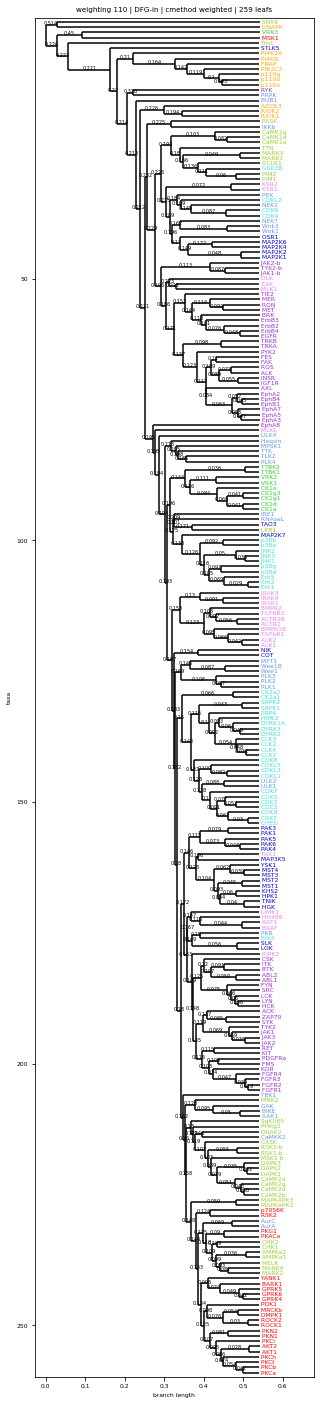

#### DFG-out

##### ward

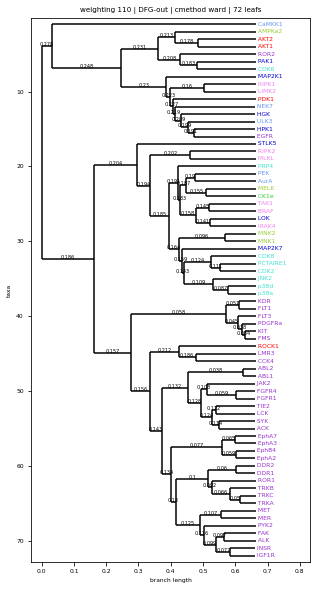

##### average

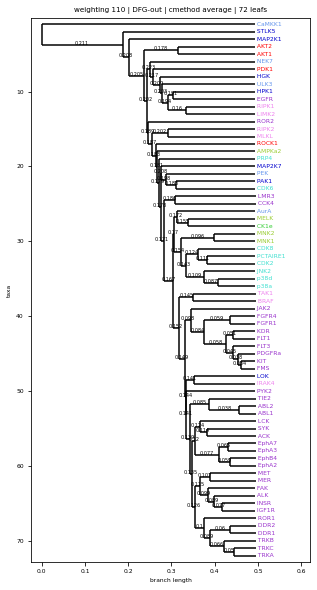

##### weighted

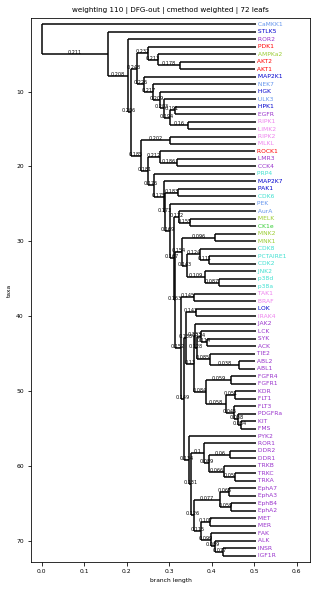

### Weighing 101

#### DFG-all

##### ward

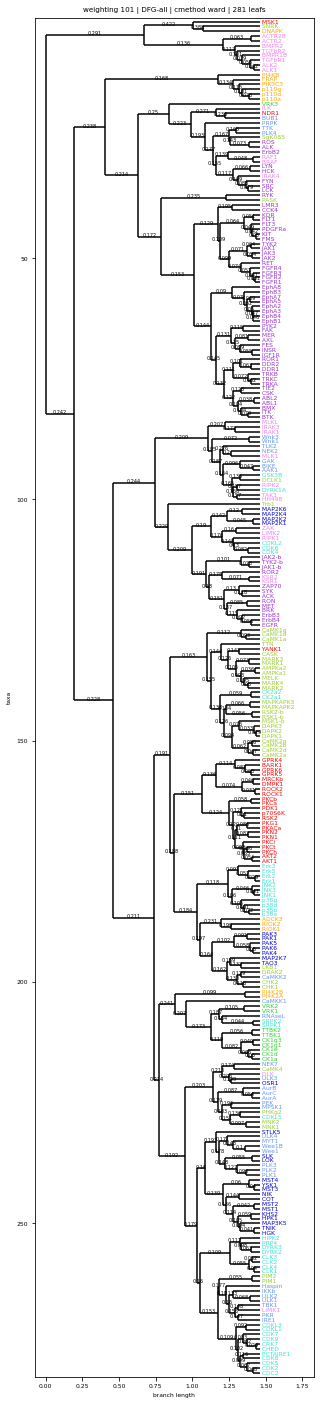

##### average

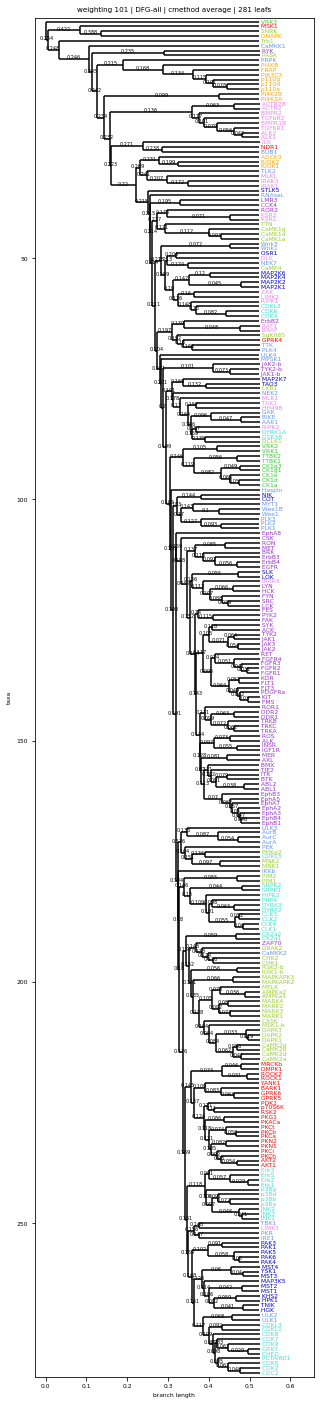

##### weighted

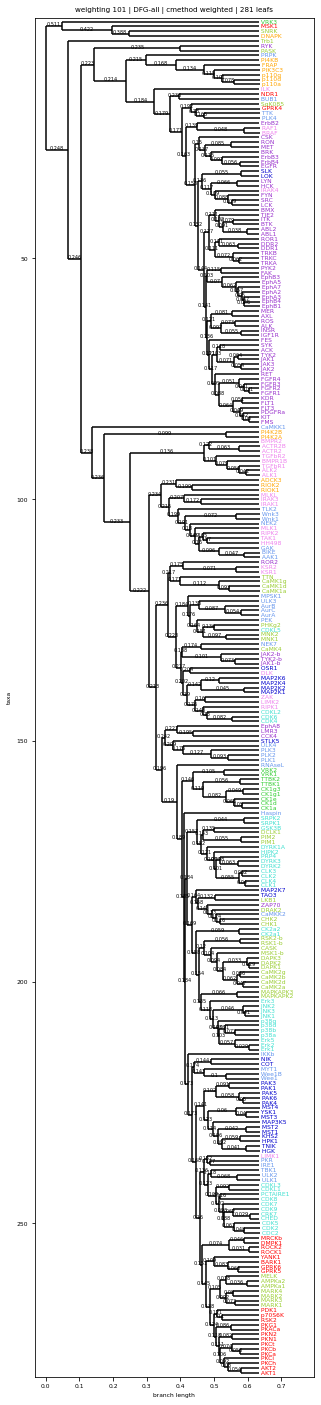

#### DFG-in

##### ward

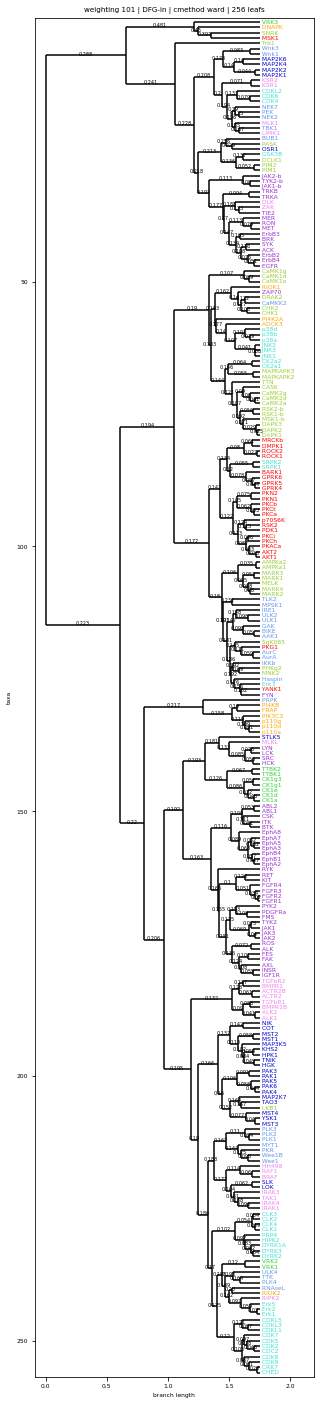

##### average

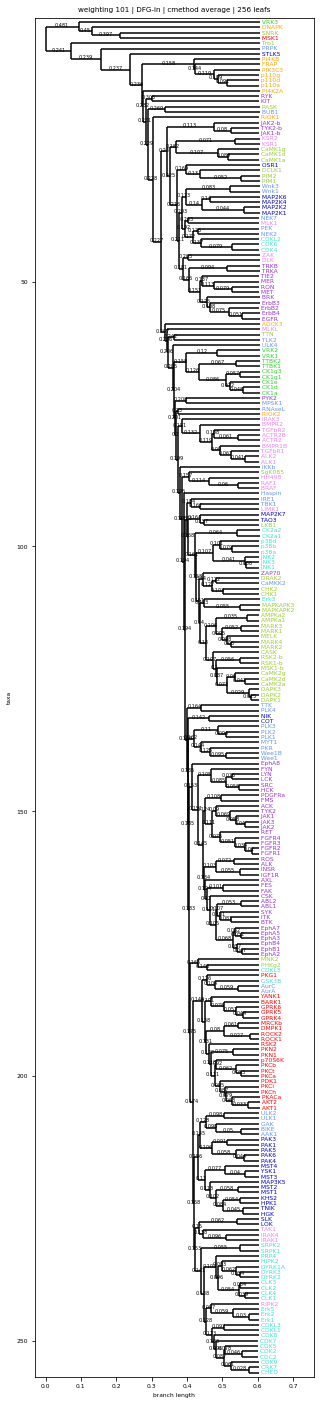

##### weighted

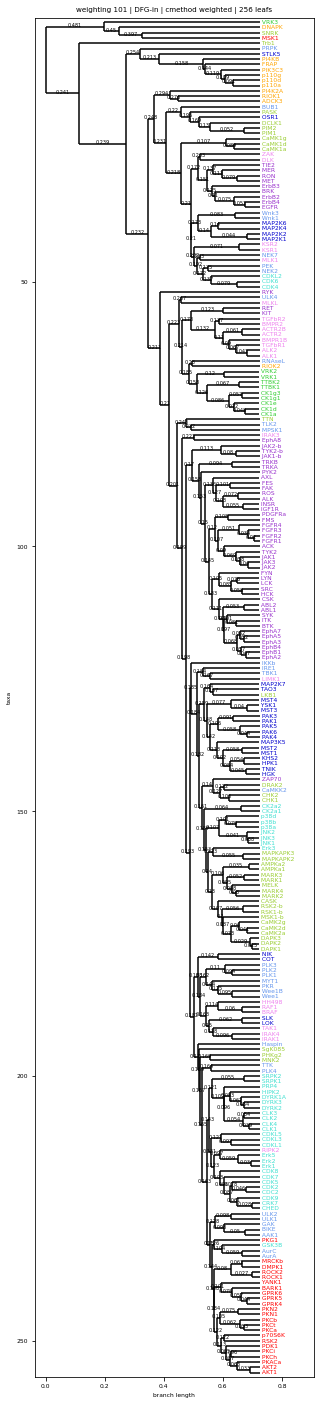

#### DFG-out

##### ward

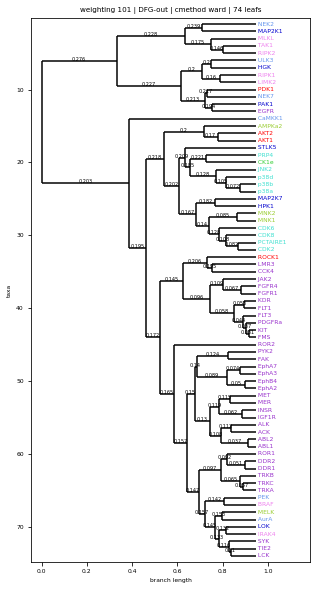

##### average

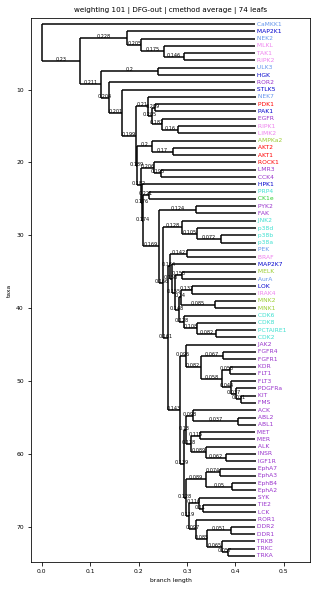

##### weighted

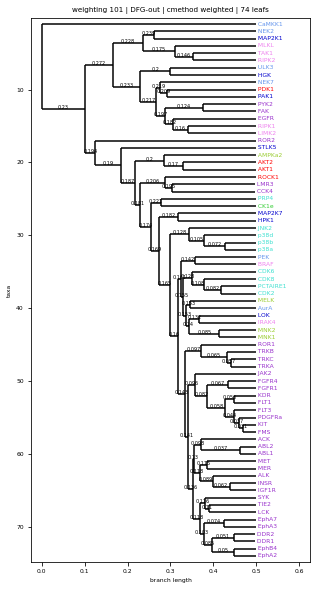

### Weighing 100

#### DFG-all

##### ward

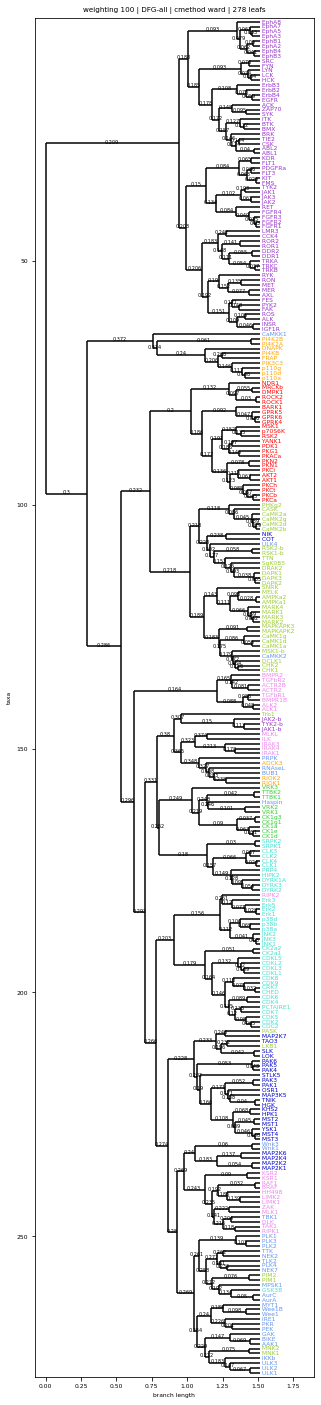

##### average

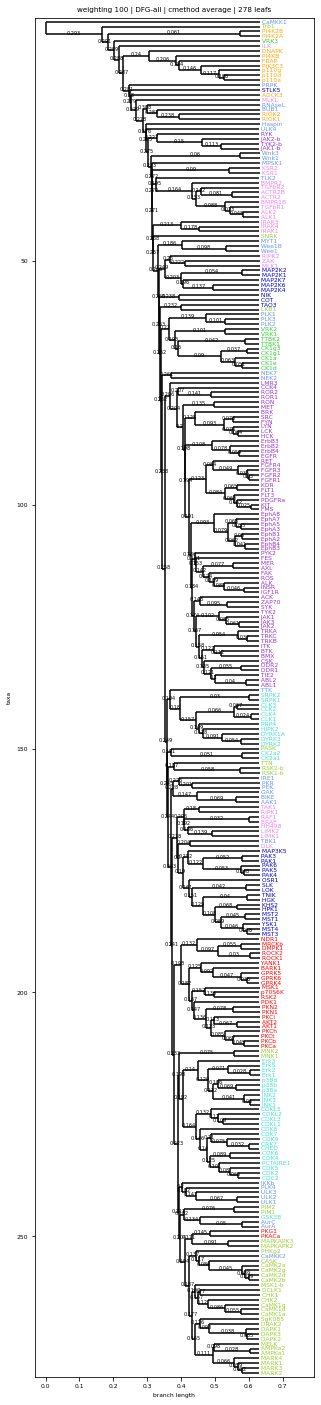

##### weighted

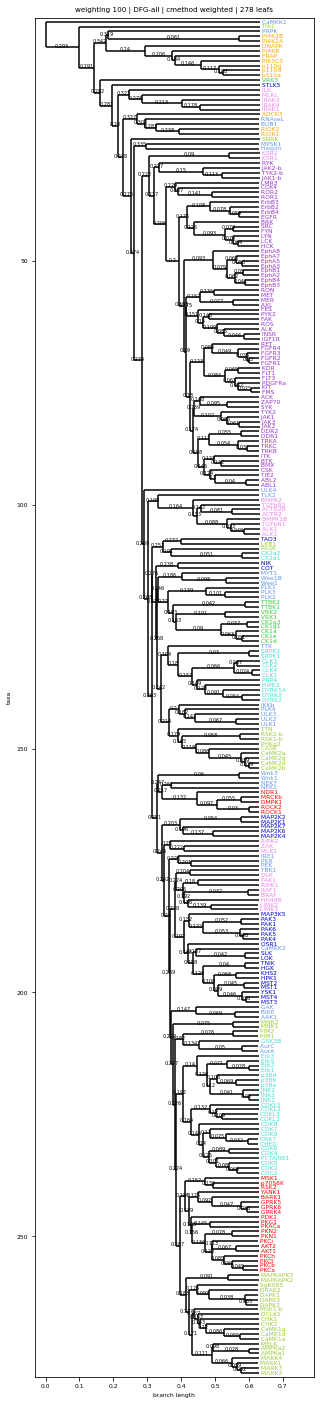

#### DFG-in

##### ward

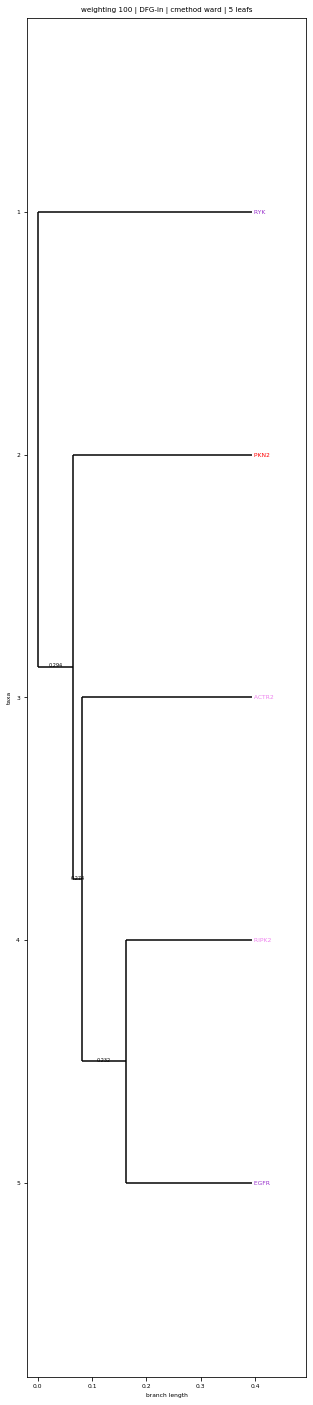

##### average

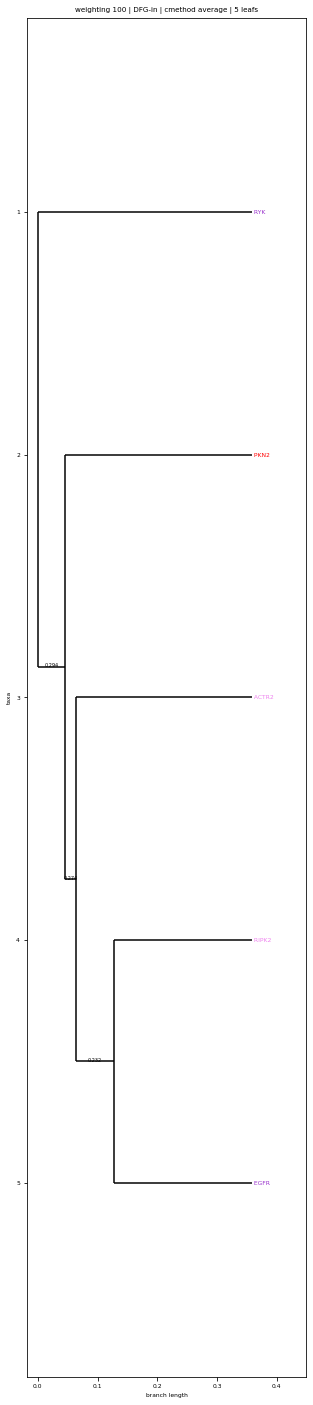

##### weighted

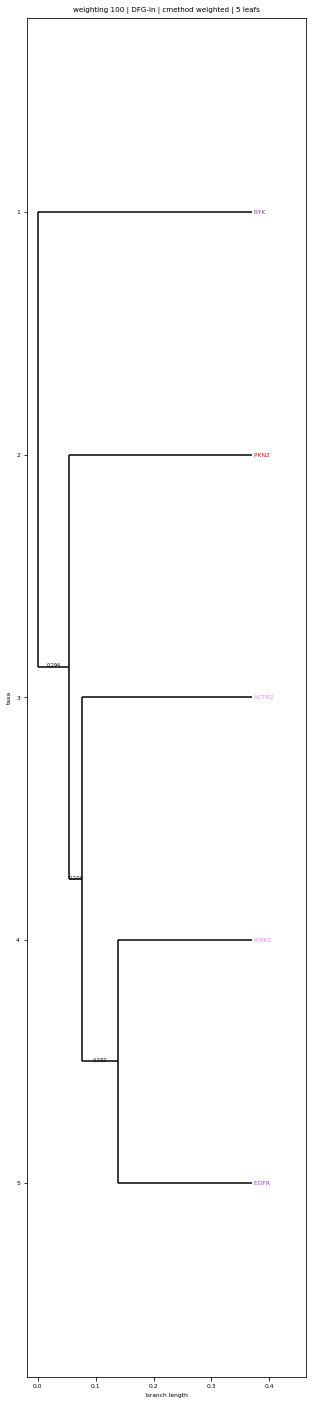

#### DFG-out

##### ward

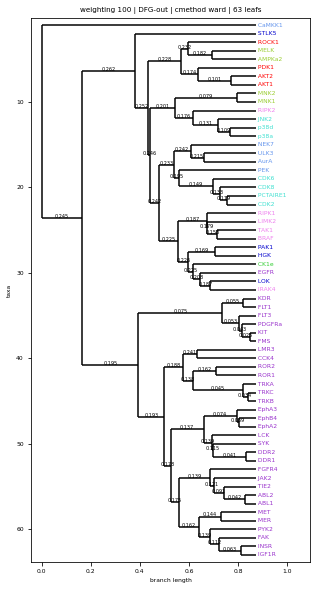

##### average

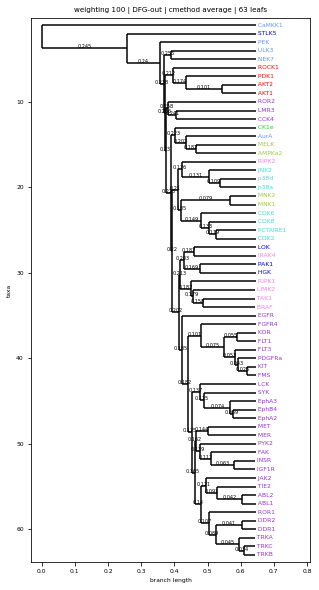

##### weighted

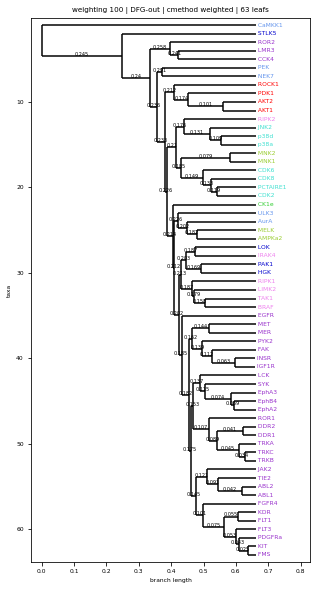

CPU times: user 39.1 s, sys: 1.6 s, total: 40.7 s
Wall time: 40.6 s


In [10]:
%%time
visualize_trees()

## Appendix: EGFR's top X kinases

In [11]:
def _top_kinases(kinase_matrix, target):

    kinases_to_target = kinase_matrix[target].sort_values()
    kinases_to_target.name = "distance"
    kinases_to_target.index.name = "kinase.klifs_name"
    kinases_to_target = kinases_to_target.reset_index()

    klifs_session = setup_remote()
    kinase_groups = klifs_session.kinases.by_kinase_name(
        kinases_to_target["kinase.klifs_name"].tolist(), species="Human"
    )[["kinase.klifs_name", "kinase.group"]]

    kinases_to_target = kinases_to_target.merge(kinase_groups)

    return kinases_to_target


def top_kinases(dfg, path_results=RESULTS, weighting_schemes=WEIGHTING_SCHEMES):

    for weighting in WEIGHTING_SCHEMES:
        display(Markdown(f"#### Weighting {weighting}"))
        path = path_results / f"dfg_{dfg}/matrices/kinase_matrix_{weighting}_{dfg}_0.8.csv"
        kinase_matrix = pd.read_csv(path, index_col=0)
        for kinase, top_n in zip(kinase_list, top_n_list):
            display(Markdown(kinase))
            display(_top_kinases(kinase_matrix, kinase)[:top_n])

In [12]:
kinase_list = ["EGFR", "SLK", "LOK"]
top_n_list = [40, 10, 10]

In [13]:
top_kinases("dfg_in")

#### Weighting 15

FileNotFoundError: [Errno 2] No such file or directory: '/home/dominique/Documents/GitHub/kissim_app/notebooks/005_comparison/../../results/dfg_dfg_in/matrices/kinase_matrix_15_dfg_in_0.8.csv'